#### Importing the required libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter('ignore')

#### Load Data

In [76]:
matches_df = pd.read_csv("D:\\cricket_dataset\\matches.csv")
matches_df.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [77]:
matches_df["date"] = pd.to_datetime(matches_df['date'])
matches_df.head(5)

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [78]:
#reshape and claculate team metrics

team_performance = matches_df.melt(
    id_vars = ["id", "season" , "date" , "winner","result","result_margin","target_runs"],
    value_vars = ["team1","team2"],
    var_name ="home_or_away",
    value_name ="team"
)

team_performance["is_winner"] = (team_performance["team"] == team_performance["winner"]).astype(int)
team_performance["runs_scored"] =team_performance["target_runs"]
team_performance["runs_conceded"] = team_performance.groupby("id")["target_runs"].transform("sum") - team_performance["target_runs"]

team_performance.head(5)

,id,season,date,winner,result,result_margin,target_runs,home_or_away,team,is_winner,runs_scored,runs_conceded
0,335982,2007/08,2008-04-18,Kolkata Knight Riders,runs,140.0,223.0,team1,Royal Challengers Bangalore,0,223.0,223.0
1,335983,2007/08,2008-04-19,Chennai Super Kings,runs,33.0,241.0,team1,Kings XI Punjab,0,241.0,241.0
2,335984,2007/08,2008-04-19,Delhi Daredevils,wickets,9.0,130.0,team1,Delhi Daredevils,1,130.0,130.0
3,335985,2007/08,2008-04-20,Royal Challengers Bangalore,wickets,5.0,166.0,team1,Mumbai Indians,0,166.0,166.0
4,335986,2007/08,2008-04-20,Kolkata Knight Riders,wickets,5.0,111.0,team1,Kolkata Knight Riders,1,111.0,111.0


In [79]:
#aggreated data for each team
team_performance_agg =team_performance.groupby(["team" ,"date"]).agg({
    "is_winner":"sum",
    "runs_scored":"sum",
    "runs_conceded":"sum"
}).sort_values("date").reset_index()

team_performance_agg["net_run_rate"] =team_performance_agg["runs_scored"] - team_performance_agg["runs_conceded"]
team_performance_agg

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
0,Royal Challengers Bangalore,2008-04-18,0,223.0,223.0,0.0
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
2,Delhi Daredevils,2008-04-19,1,130.0,130.0,0.0
3,Rajasthan Royals,2008-04-19,0,130.0,130.0,0.0
4,Kings XI Punjab,2008-04-19,0,241.0,241.0,0.0
...,...,...,...,...,...,...
2185,Royal Challengers Bengaluru,2024-05-22,0,173.0,173.0,0.0
2186,Rajasthan Royals,2024-05-24,0,176.0,176.0,0.0
2187,Sunrisers Hyderabad,2024-05-24,1,176.0,176.0,0.0
2188,Kolkata Knight Riders,2024-05-26,1,114.0,114.0,0.0


In [80]:
team_name = "Kolkata Knight Riders"
team_data = team_performance_agg[team_performance_agg["team"] ==team_name]
team_data

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
8,Kolkata Knight Riders,2008-04-20,1,111.0,111.0,0.0
22,Kolkata Knight Riders,2008-04-26,0,148.0,148.0,0.0
30,Kolkata Knight Riders,2008-04-29,0,138.0,138.0,0.0
36,Kolkata Knight Riders,2008-05-01,0,197.0,197.0,0.0
...,...,...,...,...,...,...
2149,Kolkata Knight Riders,2024-05-03,1,170.0,170.0,0.0
2152,Kolkata Knight Riders,2024-05-05,1,236.0,236.0,0.0
2167,Kolkata Knight Riders,2024-05-11,1,158.0,158.0,0.0
2182,Kolkata Knight Riders,2024-05-21,1,160.0,160.0,0.0


In [81]:
team_data = team_data.sort_values("date")

team_data.set_index("date",inplace=True)
team_data

,team,is_winner,runs_scored,runs_conceded,net_run_rate
date,,,,,
2008-04-18,Kolkata Knight Riders,1,223.0,223.0,0.0
2008-04-20,Kolkata Knight Riders,1,111.0,111.0,0.0
2008-04-26,Kolkata Knight Riders,0,148.0,148.0,0.0
2008-04-29,Kolkata Knight Riders,0,138.0,138.0,0.0
2008-05-01,Kolkata Knight Riders,0,197.0,197.0,0.0
...,...,...,...,...,...
2024-05-03,Kolkata Knight Riders,1,170.0,170.0,0.0
2024-05-05,Kolkata Knight Riders,1,236.0,236.0,0.0
2024-05-11,Kolkata Knight Riders,1,158.0,158.0,0.0


In [82]:
# Select the column to predict (runs scored)
time_series = team_data['runs_scored']

# Stationarity Check (ADF Test)
adf_result = adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] > 0.05:
    print("The series is not stationary. Differencing is required.")

ADF Statistic: -7.214074913565805
p-value: 2.1963196715516947e-10


In [83]:
if adf_result[1] >0.05:
  time_series_diff = time_series.diff().dropna()
else:
  time_series_diff = time_series


In [84]:
train_size  = int(len(time_series_diff)*0.8)

train ,test = time_series_diff[:train_size] , time_series_diff[train_size:]

In [85]:
model = ARIMA(train , order =(1,1,1))
fitted_model = model.fit()

In [86]:
forecast  = fitted_model.forecast(steps =len(test))
forecast.index =test.index
forecast.head(5)

date
2021-09-23    160.975878
2021-09-26    166.173245
2021-09-28    166.570630
2021-10-01    166.601014
2021-10-03    166.603337
Name: predicted_mean, dtype: float64

In [87]:
import numpy as np
actual_runs = test.values
forecast_runs = forecast.values

mae = np.mean(np.abs(actual_runs - forecast_runs))
print(f"Mean Absolute Error (MAE): ",mae )
rmse  = np.sqrt(np.mean((actual_runs - forecast_runs)**2))
print(f"Root Mean Squared Error (RMSE): ",rmse )


Mean Absolute Error (MAE):  28.842283374084072
Root Mean Squared Error (RMSE):  37.52137652372836


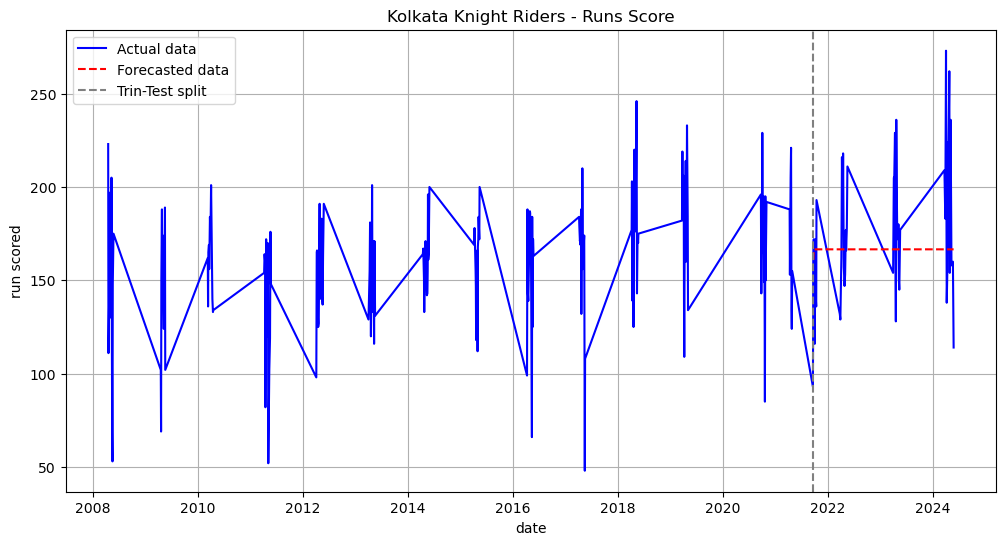

In [88]:
plt.figure(figsize = (12, 6))
plt.plot(time_series_diff , label ="Actual data" , color ="blue")
plt.plot(forecast ,label ="Forecasted data" , color="red", linestyle ="--")
plt.axvline(x =test.index[0], color="gray", linestyle = "--",label = "Trin-Test split")
plt.title(f"{team_name} - Runs Score")
plt.xlabel("date")
plt.ylabel("run scored")
plt.legend()
plt.grid()
plt.show()

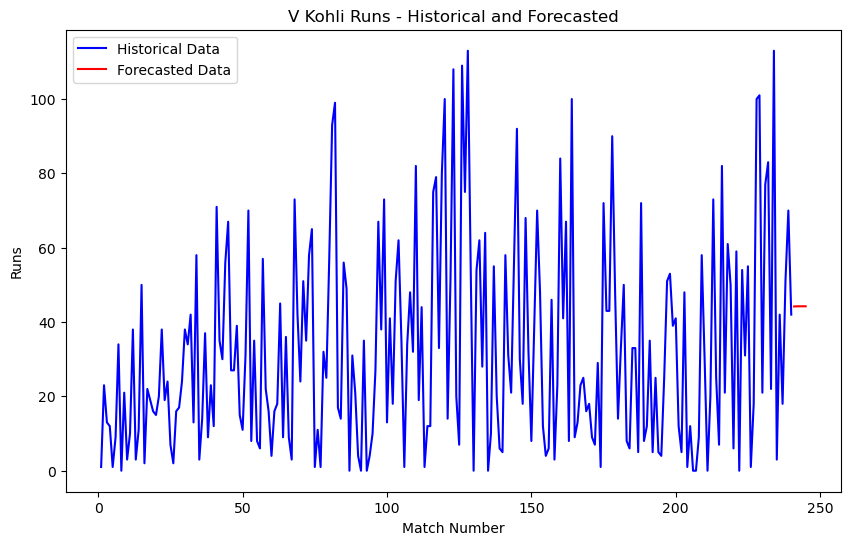

240    44.189547
241    44.237983
242    44.239054
243    44.239078
244    44.239078
Name: predicted_mean, dtype: float64


In [89]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('D:\\cricket_dataset\\deliveries.csv')

# Filter data for the specific player
kohli_scores = data[data['batter'] == 'V Kohli']

# Group data by match and summarize
kohli_scores = kohli_scores.groupby('match_id')['batsman_runs'].sum().reset_index()

# Compute total runs scored by the player
total_runs = kohli_scores['batsman_runs'].sum()

# Select subset of matches
kohli_scores = kohli_scores.head(240)

# Prepare data for ARIMA
kohli_scores['match_number'] = range(1, len(kohli_scores) + 1)
kohli_scores.set_index('match_number', inplace=True)

# Fit the ARIMA model
model = ARIMA(kohli_scores['batsman_runs'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast future matches
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(kohli_scores['batsman_runs'], label='Historical Data', color='blue')
plt.plot(range(len(kohli_scores) + 1, len(kohli_scores) + 1 + forecast_steps),
         forecast, label='Forecasted Data', color='red')
plt.title('V Kohli Runs - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Runs')
plt.legend()
plt.show()

# Print forecasted values
print(forecast)


In [90]:
data.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
       'total_runs', 'extras_type', 'is_wicket', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

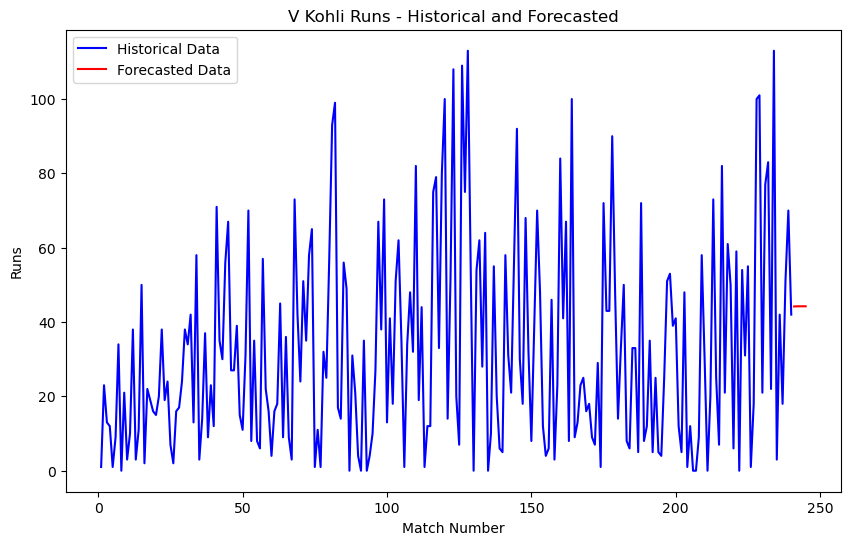

Forecast for V Kohli:
240    44.189547
241    44.237983
242    44.239054
243    44.239078
244    44.239078
Name: predicted_mean, dtype: float64


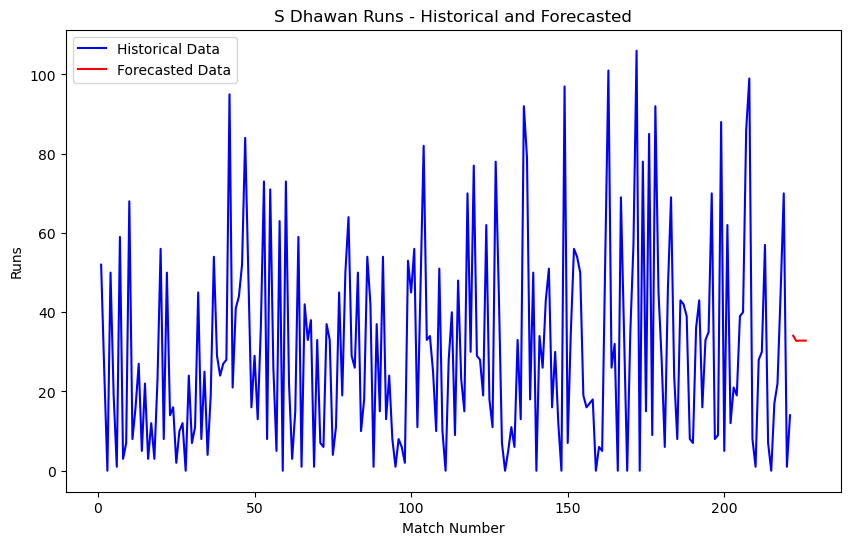

Forecast for S Dhawan:
221    34.077027
222    32.753424
223    32.840684
224    32.834931
225    32.835310
Name: predicted_mean, dtype: float64


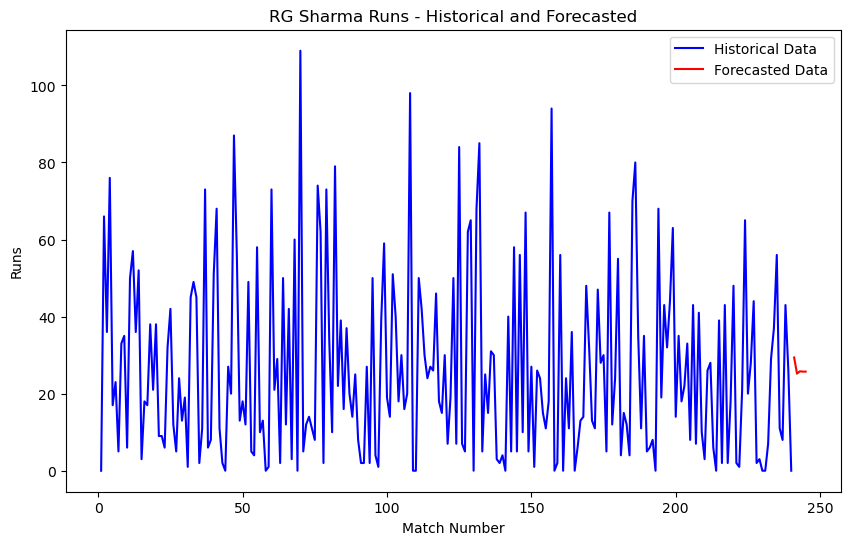

Forecast for RG Sharma:
240    29.385569
241    25.205612
242    25.800191
243    25.715615
244    25.727646
Name: predicted_mean, dtype: float64


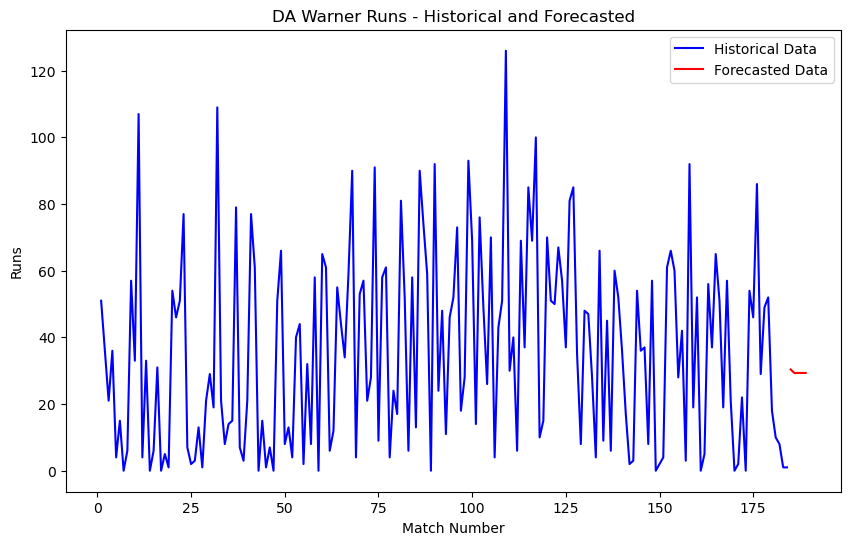

Forecast for DA Warner:
184    30.375157
185    29.294774
186    29.334510
187    29.333048
188    29.333102
Name: predicted_mean, dtype: float64


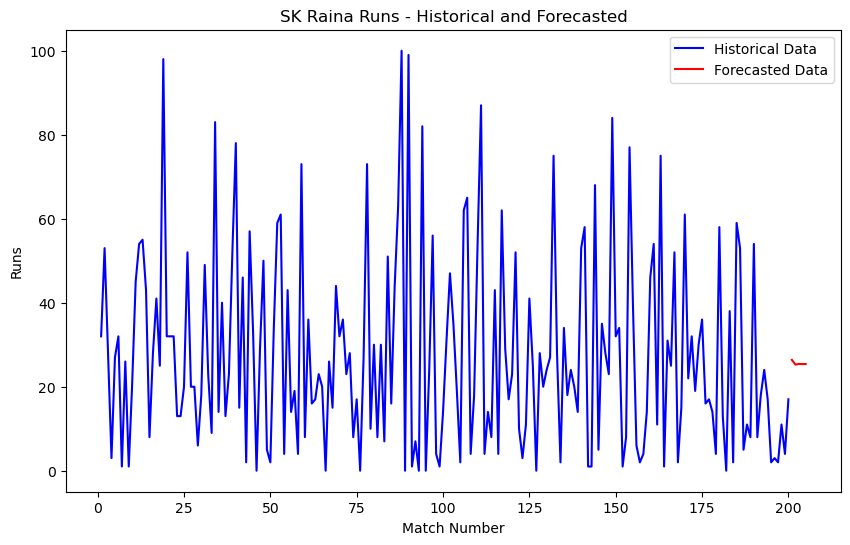

Forecast for SK Raina:
200    26.396030
201    25.281171
202    25.413451
203    25.397756
204    25.399618
Name: predicted_mean, dtype: float64


In [91]:
# Calculate total runs scored by each batter
batter_scores = data.groupby('batter')['batsman_runs'].sum().reset_index()
batter_scores = batter_scores.sort_values(by='batsman_runs', ascending=False).head(5)

# Iterate through the top 5 batters
forecasts = {}
for batter in batter_scores['batter']:
    # Filter data for the specific player
    player_scores = data[data['batter'] == batter]

    # Group data by match and summarize
    player_scores = player_scores.groupby('match_id')['batsman_runs'].sum().reset_index()

    # Select subset of matches
    player_scores = player_scores.head(240)

    # Prepare data for ARIMA
    player_scores['match_number'] = range(1, len(player_scores) + 1)
    player_scores.set_index('match_number', inplace=True)

    # Fit the ARIMA model
    model = ARIMA(player_scores['batsman_runs'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast future matches
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    forecasts[batter] = forecast

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(player_scores['batsman_runs'], label='Historical Data', color='blue')
    plt.plot(range(len(player_scores) + 1, len(player_scores) + 1 + forecast_steps),
             forecast, label='Forecasted Data', color='red')
    plt.title(f'{batter} Runs - Historical and Forecasted')
    plt.xlabel('Match Number')
    plt.ylabel('Runs')
    plt.legend()
    plt.show()

    # Print forecasted values for the player
    print(f"Forecast for {batter}:")
    print(forecast)

# Time Series Analysis of Bowlers

In [93]:
bowler_stats = data.groupby(['match_id', 'bowler']).agg(
    total_wickets=('is_wicket', 'sum'),
    total_runs=('total_runs', 'sum')
).reset_index()
bowler_stats

,match_id,bowler,total_wickets,total_runs
0,335982,AA Noffke,1,41
1,335982,AB Agarkar,3,25
2,335982,AB Dinda,2,9
3,335982,CL White,0,24
4,335982,I Sharma,1,13
...,...,...,...,...
12973,1426312,PJ Cummins,1,18
12974,1426312,SP Narine,1,20
12975,1426312,Shahbaz Ahmed,1,28
12976,1426312,T Natarajan,0,29


In [94]:
bowler_performance = bowler_stats.groupby('bowler').agg(
    total_wickets=('total_wickets', 'sum'),
    total_runs=('total_runs', 'sum'),
    matches_played=('match_id', 'count')
).reset_index()
bowler_performance['economy_rate'] = bowler_performance['total_runs'] / (bowler_performance['matches_played'] * 6)
bowler_performance['wickets_per_match'] = bowler_performance['total_wickets'] / bowler_performance['matches_played']


## Time Series Analysis of best bowler 

In [96]:
top_bowlers = bowler_performance.sort_values(by='total_wickets', ascending=False).head(1)
selected_bowler = top_bowlers.iloc[0]['bowler']

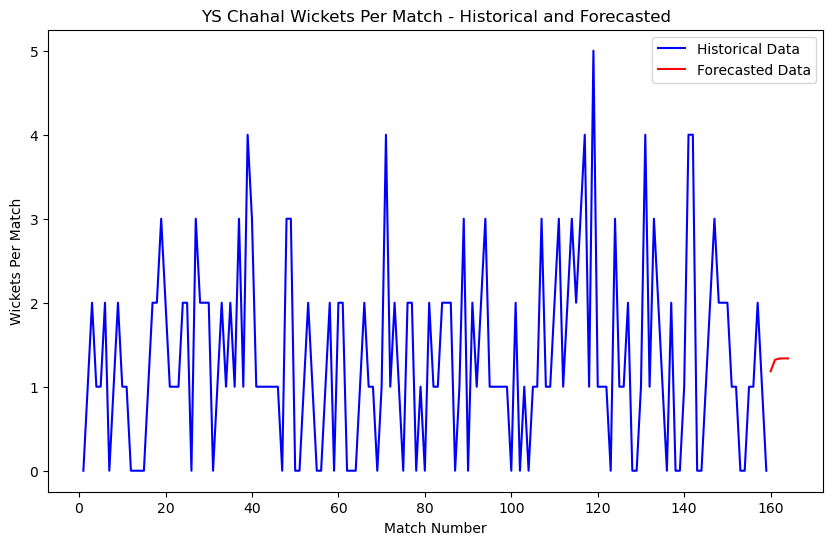

Forecast for YS Chahal:
159    1.184504
160    1.319960
161    1.335451
162    1.337222
163    1.337425
Name: predicted_mean, dtype: float64


In [97]:
selected_bowler_stats = bowler_stats[bowler_stats['bowler'] == selected_bowler]

selected_bowler_stats = selected_bowler_stats.groupby('match_id').agg(
    wickets_per_match=('total_wickets', 'sum')
).reset_index()
selected_bowler_stats['match_number'] = range(1, len(selected_bowler_stats) + 1)
selected_bowler_stats.set_index('match_number', inplace=True)

# Fit the ARIMA model
model = ARIMA(selected_bowler_stats['wickets_per_match'], order=(1, 1, 1))
model_fit = model.fit()

# Forecasting
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(selected_bowler_stats['wickets_per_match'], label='Historical Data', color='blue')
plt.plot(range(len(selected_bowler_stats) + 1, len(selected_bowler_stats) + 1 + forecast_steps),
         forecast, label='Forecasted Data', color='red')
plt.title(f'{selected_bowler} Wickets Per Match - Historical and Forecasted')
plt.xlabel('Match Number')
plt.ylabel('Wickets Per Match')
plt.legend()
plt.show()

# Print forecasted values
print(f"Forecast for {selected_bowler}:")
print(forecast)


## Time Series Analysis of Top 5 Bowlers

In [99]:
top_bowlers = bowler_performance.sort_values(by='total_wickets', ascending=False).head(5)
top_bowlers

,bowler,total_wickets,total_runs,matches_played,economy_rate,wickets_per_match
524,YS Chahal,213,4681,159,4.906709,1.339623
119,DJ Bravo,207,4436,158,4.679325,1.310127
348,PP Chawla,201,5179,191,4.519197,1.052356
446,SP Narine,200,4672,175,4.449524,1.142857
355,R Ashwin,198,5435,208,4.354968,0.951923


In [100]:
import seaborn as sns

<Axes: xlabel='bowler', ylabel='total_wickets'>

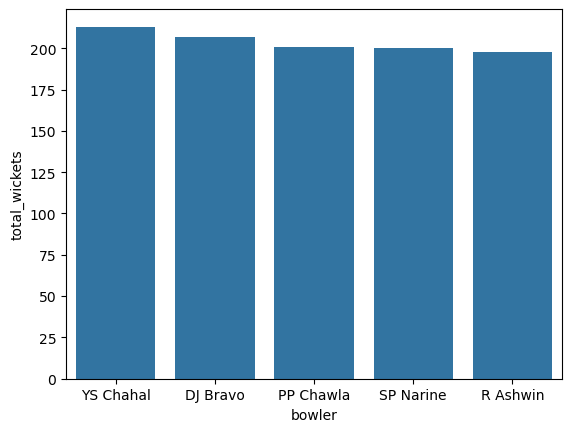

In [101]:
sns.barplot(x='bowler',y='total_wickets',data=top_bowlers)

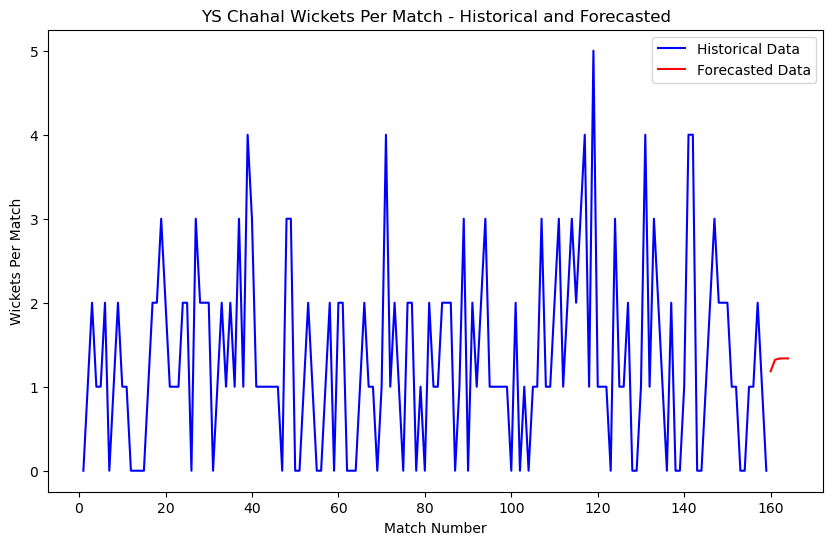

Forecast for YS Chahal:
159    1.184504
160    1.319960
161    1.335451
162    1.337222
163    1.337425
Name: predicted_mean, dtype: float64


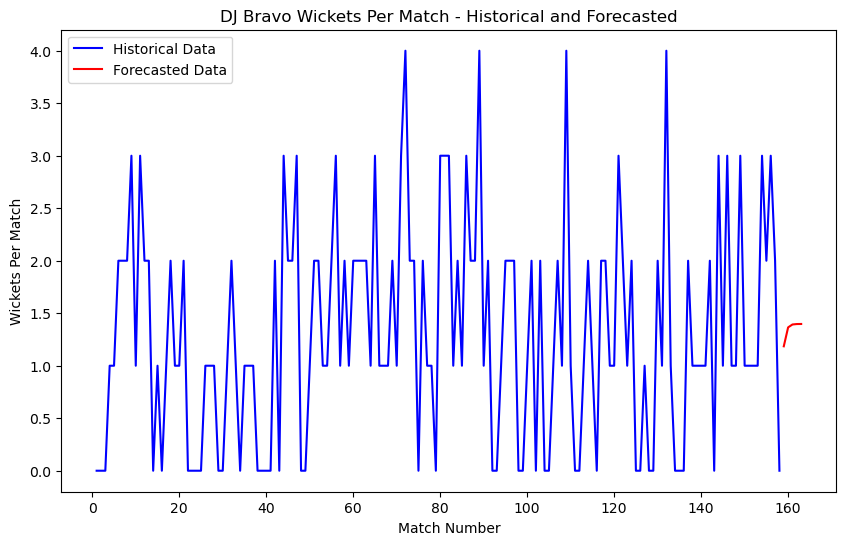

Forecast for DJ Bravo:
158    1.184908
159    1.365293
160    1.392754
161    1.396934
162    1.397571
Name: predicted_mean, dtype: float64


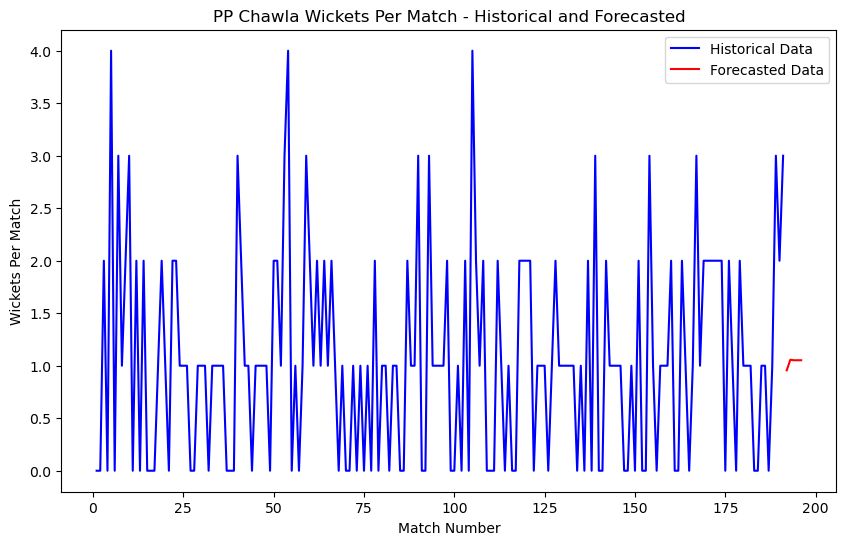

Forecast for PP Chawla:
191    0.956117
192    1.056875
193    1.051908
194    1.052153
195    1.052141
Name: predicted_mean, dtype: float64


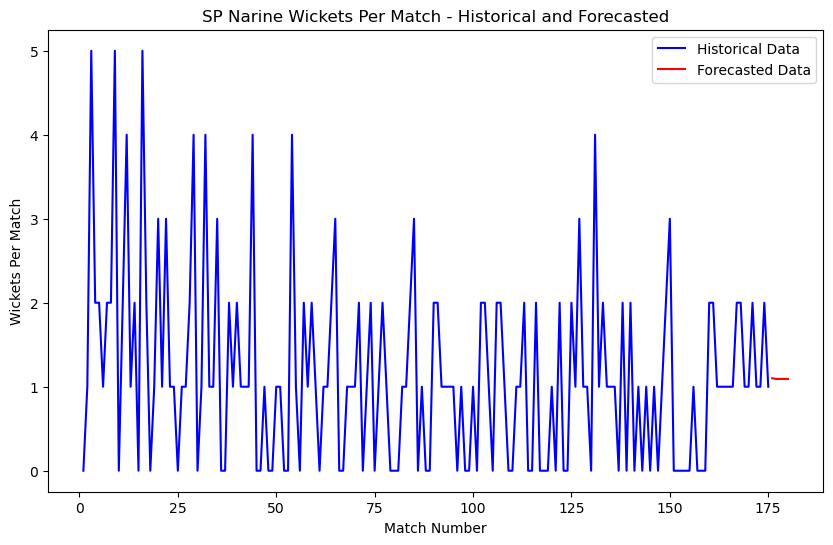

Forecast for SP Narine:
175    1.101301
176    1.091758
177    1.092657
178    1.092572
179    1.092580
Name: predicted_mean, dtype: float64


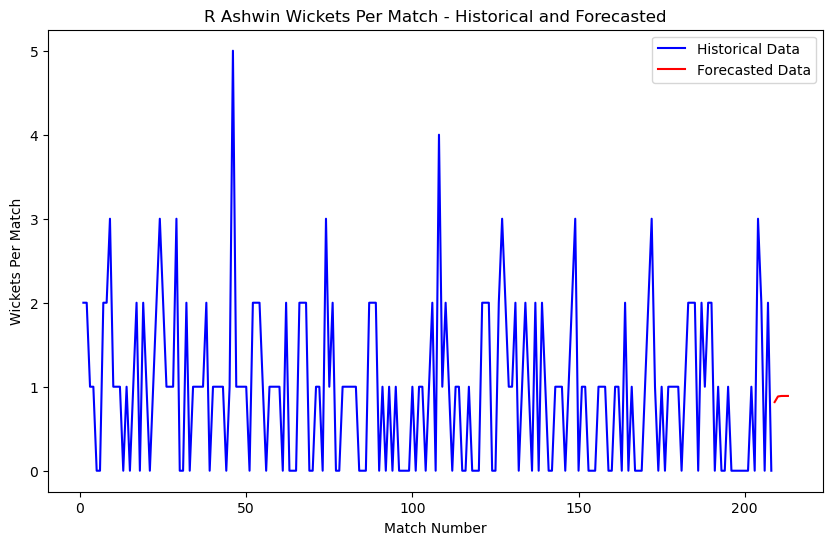

Forecast for R Ashwin:
208    0.817042
209    0.884181
210    0.889698
211    0.890152
212    0.890189
Name: predicted_mean, dtype: float64


In [102]:
forecasts = {}
for bowler in top_bowlers['bowler']:
    selected_bowler_stats = bowler_stats[bowler_stats['bowler'] == bowler]

    selected_bowler_stats = selected_bowler_stats.groupby('match_id').agg(
        wickets_per_match=('total_wickets', 'sum')
    ).reset_index()
    selected_bowler_stats['match_number'] = range(1, len(selected_bowler_stats) + 1)
    selected_bowler_stats.set_index('match_number', inplace=True)

    # Fit the ARIMA model
    model = ARIMA(selected_bowler_stats['wickets_per_match'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    forecasts[bowler] = forecast

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(selected_bowler_stats['wickets_per_match'], label='Historical Data', color='blue')
    plt.plot(range(len(selected_bowler_stats) + 1, len(selected_bowler_stats) + 1 + forecast_steps),
             forecast, label='Forecasted Data', color='red')
    plt.title(f'{bowler} Wickets Per Match - Historical and Forecasted')
    plt.xlabel('Match Number')
    plt.ylabel('Wickets Per Match')
    plt.legend()
    plt.show()

    # Print forecasted values for the bowler
    print(f"Forecast for {bowler}:")
    print(forecast)